In [1]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
import joblib
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
import catboost

In [3]:
train = pd.read_csv("../data/onti_c.csv")


In [4]:
#важные колонки для использования
val_col = ['Coolness_RHEED',  'R FWHM_RHEED',  'X FWHM_RHEED', 'Y FWHM_RHEED',
        'Filtered Rate', 'Raw Rate',
       'Source Power', 'Crystal Position']


In [5]:
#создаем датасет разными аггрегационными функциями
def generated_dataset(series, wind_size=5):
    result = series.rolling(wind_size).agg(['mean', 'std', 'var'])
    delta = series - series.shift(wind_size)
    delta.columns = [col+'_'+str(wind_size) for col in delta.columns]
    result.columns = [col[0]+'_'+col[1]+'_'+str(wind_size) for col in result.columns]
    result = result.join(delta)
    return result

In [6]:
df_X = generated_dataset(train[val_col])
df_X.shape, df_X.columns

((2363772, 32),
 Index(['Coolness_RHEED_mean_5', 'Coolness_RHEED_std_5', 'Coolness_RHEED_var_5',
        'R FWHM_RHEED_mean_5', 'R FWHM_RHEED_std_5', 'R FWHM_RHEED_var_5',
        'X FWHM_RHEED_mean_5', 'X FWHM_RHEED_std_5', 'X FWHM_RHEED_var_5',
        'Y FWHM_RHEED_mean_5', 'Y FWHM_RHEED_std_5', 'Y FWHM_RHEED_var_5',
        'Filtered Rate_mean_5', 'Filtered Rate_std_5', 'Filtered Rate_var_5',
        'Raw Rate_mean_5', 'Raw Rate_std_5', 'Raw Rate_var_5',
        'Source Power_mean_5', 'Source Power_std_5', 'Source Power_var_5',
        'Crystal Position_mean_5', 'Crystal Position_std_5',
        'Crystal Position_var_5', 'Coolness_RHEED_5', 'R FWHM_RHEED_5',
        'X FWHM_RHEED_5', 'Y FWHM_RHEED_5', 'Filtered Rate_5', 'Raw Rate_5',
        'Source Power_5', 'Crystal Position_5'],
       dtype='object'))

In [7]:
df_X = df_X.join(generated_dataset(train[val_col],wind_size=50))
df_X.shape

(2363772, 64)

In [8]:
df_X = df_X.join(generated_dataset(train[val_col],wind_size=500))
df_X.shape

(2363772, 96)

In [9]:
df_X = df_X.join(generated_dataset(train[val_col],wind_size=1500))
df_X.shape

(2363772, 128)

In [10]:
mask_base = df_X.isna().sum(axis=1)==0
df_X.shape

(2363772, 128)

In [11]:
mask_base.sum()

2287456

In [12]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

wind_size = 435

df = df_X[wind_size:-wind_size]
#y = (rheed_long.Coolness < rheed_long.Coolness.shift(wind_size) )
#y = y[wind_size:-wind_size]
cool_col = 'Coolness_RHEED_mean_50'
y = (abs((df[cool_col].shift(wind_size) -  df[cool_col]))>5)


mask = mask_base #&(y>30)
df = df[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, shuffle=False)

lg = make_pipeline(StandardScaler(), sklearn.linear_model.LogisticRegression())#alpha=1000))

lg.fit(X_train, y_train)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(lg.predict(X_test), y_test)

ImportError: cannot import name 'auc_score' from 'sklearn.metrics' (/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [13]:
import pickle
with open("model.pkl","wb") as f:
    pickle.dump(lg,f)

In [14]:
y_test.value_counts()

False    544078
True      27786
Name: Coolness_RHEED_mean_50, dtype: int64

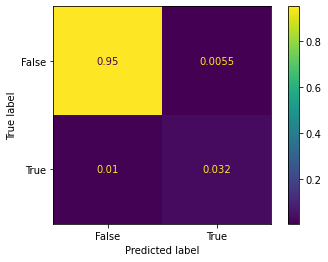

In [15]:
sklearn.metrics.plot_confusion_matrix(lg, X_train, y_train,normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

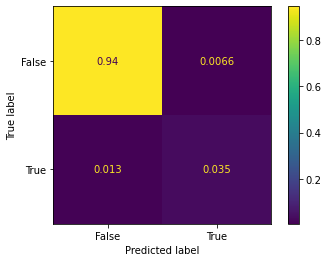

In [16]:
sklearn.metrics.plot_confusion_matrix(lg, X_test, y_test,normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

In [17]:
import copy
#lg = lgs[2]
list_val= lg[1].coef_[0]
#list_val = copy.deepcopy(lg[1].coef_)
#list_val = list_val[0]
top_five_ind = [(list_val[np.argmax(np.abs(list_val) )],X_train.columns[np.argmax(np.abs(list_val))] )]
list_val[np.argmax(np.abs(list_val))] = 0 
for k in range(55):
    top_five_ind.append((list_val[np.argmax(np.abs(list_val))],
                        X_train.columns[np.argmax(np.abs(list_val))]))
    list_val[np.argmax(np.abs(list_val))] = 0 

top_five_ind[:5]

[(3.7679730512372442, 'Coolness_RHEED_std_500'),
 (-1.8930788040404605, 'Coolness_RHEED_var_500'),
 (1.6162773607901157, 'Coolness_RHEED_std_1500'),
 (-1.3146533588846676, 'X FWHM_RHEED_std_500'),
 (-1.1288655328149384, 'X FWHM_RHEED_std_1500')]

In [18]:
sklearn.metrics.f1_score(y_test, lg.predict_proba(X_test)[:,1]>0.1), sklearn.metrics.precision_score(y_test, lg.predict(X_test)), sklearn.metrics.recall_score(y_test, lg.predict(X_test))

(0.06435501337046123, 0.06941230911614993, 0.010796804145972791)

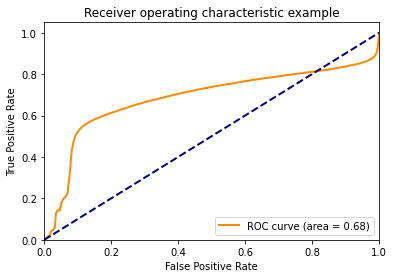

In [19]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, lg.predict_proba(X_test)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_test, lg.predict_proba(X_test)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [21]:
(y_train != lg.predict(X_train)).value_counts()

False    1639554
True       76038
Name: Coolness_RHEED_mean_50, dtype: int64

In [22]:
(y_test != lg.predict(X_test)).value_counts()


False    540356
True      31508
Name: Coolness_RHEED_mean_50, dtype: int64

In [23]:
lg.decision_function(X_test)

array([-5.40460446, -5.39447981, -5.45365043, ..., -3.33224093,
       -3.29994936, -3.28630449])